In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.api import ARIMA
from statsmodels.stats.api import het_arch, acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_predict

import pandas_datareader.data as web

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

<AxesSubplot:xlabel='DATE'>

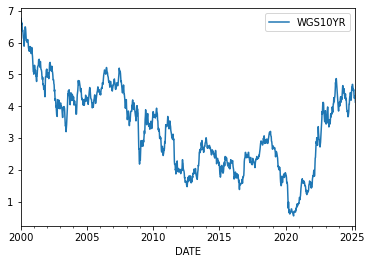

In [2]:
y = web.DataReader(name='WGS10YR', data_source='fred', start='2000-01-01')
y.plot()

In [3]:
# спецификация модели
mod = ARIMA(y, order=(2,1,1), missing='drop')
# подгонка модели на данных
res = mod.fit(trend='c')
# выводим результаты подгонки
res.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.WGS10YR   No. Observations:                 1317
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1192.404
Method:                       css-mle   S.D. of innovations              0.098
Date:                Sun, 13 Apr 2025   AIC                          -2374.808
Time:                        21:28:47   BIC                          -2348.892
Sample:                    01-14-2000   HQIC                         -2365.090
                         - 04-04-2025                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0019      0.003     -0.541      0.588      -0.009       0.005
ar.L1.D.WGS10YR    -0.2301      0.390     -0.589      0.556      -0.995       0.535
ar.L2.D.WGS10YR     0.0895      0.095      0.939      0.348      -0.097       0.276
ma.L1.D.WGS10YR     0.4600      0.389      1.184      0.237      -0.302       1.222
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.2957           +0.0000j            2.2957            0.5000
AR.2            4.8654           +0.0000j            4.8654            0.0000
MA.1           -2.1738           +0.0000j            2.1738            0.5000
-----------------------------------------------------------------------------
"""

In [4]:
res.plot_diagnostics(lags=15)

plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_diagnostics'

# Auotocorrelation test

In [11]:
# корректировка степеней свободы: число оцениваемых коэффициентов = число параметров - 1 (-sigma2)
model_df = len(res.params)-1
# для тест отбрасываем первые d остатков (d=mod.k_diff)
acorr_ljungbox(res.resid[mod.k_diff:] , lags=[6], model_df=model_df)

(array([6.48950074]), array([0.09007749]))

### Серийная корреляция отсутствует

# Тест на гетероскедастичность (на ARCH-эффекты)


In [17]:
# корректировка степеней свободы: число оцениваемых коэффициентов = число параметров - 1 (т.е. -sigma2, которая не учитывается в тесте)
model_df = len(res.params)-1
# для тест отбрасываем первые d остатков (d=mod.k_diff)
lm_stat, lm_pval, f_stat, f_pval = het_arch(res.resid[mod.k_diff:], nlags=6, ddof=model_df)

lm_pval, lm_stat,  f_stat, f_pval

(6.391484890930901e-27,
 136.18558810119495,
 25.260169259457644,
 1.7473327177540502e-28)

In [13]:
from scipy.stats import chi2
print('CHI2_crit = ', chi2.isf(0.05, df=6-model_df))

CHI2_crit =  7.814727903251178


### Гетероскедастичность присутствует

In [13]:
import numpy as np
import pandas as pd

from sktime.forecasting.arima import ARIMA, AutoARIMA
# from sktime.forecasting.arima import StatsModelsARIMA
# from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.utils.plotting import plot_series
# временной горизонт для прогнозирования
from sktime.forecasting.base import ForecastingHorizon

import pandas_datareader.data as web

# тесты диагностики
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [15]:
y = web.DataReader(name='WGS10YR', data_source='fred', start='2000-01-01')

In [16]:
forecaster = AutoARIMA(information_criterion='bic', test='kpss', seasonal=True)
forecaster.fit(y)
forecaster.get_fitted_params() #['order']

{'ar.L1': 0.22772508877865968,
 'sigma2': 0.009551265278030255,
 'order': (1, 1, 0),
 'seasonal_order': (0, 0, 0, 0),
 'aic': -2382.1243439820464,
 'aicc': -2382.1152046065704,
 'bic': -2371.759639758276,
 'hqic': -2378.237836295654}